<a href="https://colab.research.google.com/github/Raukk/AutoOneCyclePolicy/blob/master/onecycle_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
'''Train a simple deep CNN on the CIFAR10 small images dataset.
It gets to 75% validation accuracy in 25 epochs, and 79% after 50 epochs.
(it's still underfitting at that point, though).
'''

from __future__ import print_function
import matplotlib.pyplot as plt

import keras
import keras.backend as K
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, LeakyReLU, BatchNormalization
from keras import optimizers
from keras.callbacks import *
from keras.layers.core import Lambda
from keras import regularizers

import os
import random
import math
import scipy
from scipy import signal 
import numpy as np


batch_size = 256#128#512#
num_classes = 10
epochs = 100
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

In [10]:
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255



x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [0]:


def build_model():
    # Build the network of vgg for 10 classes with massive dropout and weight decay as described in the paper.
    weight_decay = 0.0005
    x_shape = [32,32,3]
    model = Sequential()
    weight_decay = weight_decay

    model.add(Conv2D(64, (3, 3), padding='same',
                     input_shape=x_shape,kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Conv2D(64, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))


    model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))


    model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(512,kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    return model



In [0]:
model = build_model()



In [0]:
from keras.callbacks import *


class CyclicLR(Callback):

    def __init__(self, 
                 batches_per_epoch,
                 epoch_per_cycle = 2,
                 smoothing_factor = 5,

                 lr_min = -10.0,
                 lr_max = 0.0,                 
                 lr_depth = 10,
                 lr_decay=0.95,
                 
                 momentum_depth = 1.25,
                 
                 clipnorm_multiple = 5.0,                 

                 decay_hyper_params = True,
                 default_searching_clip = True,
                 default_searching_momentum = True,
                 default_searching_decay = True                 
                 
                ):
        super(CyclicLR, self).__init__()
        
        self.batches_per_epoch = batches_per_epoch
        self.epoch_per_cycle = epoch_per_cycle
        self.smoothing_factor = smoothing_factor
        
        self.lr_min = lr_min
        self.lr_max = lr_max
        self.lr_depth = lr_depth
        self.lr_decay = lr_decay
       
        self.momentum_depth = momentum_depth
                
        self.clipnorm_multiple = clipnorm_multiple
          
        self.decay_hyper_params = decay_hyper_params
        self.default_searching_clip = default_searching_clip
        self.default_searching_momentum = default_searching_momentum
        self.default_searching_decay = default_searching_decay
        
    def _reset(self):
           
        self.base_lr = 0.0
        self.max_lr = 1.0
        
        self.base_clipnorm = 1.0

        self.base_momentum = 1.0
        self.min_momentum = 0.50
        
        self.base_decay = 0.0

        self.rate_schedule = []
        self.clipnorm_schedule = []
        self.momentum_schedule = []
        self.decay_schedule = []

        self.ascending = False

        self.loss_history = []
        self.epoch_loss_history = []
        self.lr_history = []        
        self.clipnorm_history = []
        self.momentum_history = []
        self.decay_history = []

        # redo finding the optimum values
        self.find_all()
     
  
    def find_all(self):
        # set to begin searching values
        self.searching = True  
      
        # All optomizers have LR and ClipNorm as values
        self.searching_lr = True 
        
        self.searching_clip = self.default_searching_clip
        
        # check if it has a momentum
        if hasattr(self.model.optimizer, 'momentum'):
            self.searching_momentum = self.default_searching_momentum
        else:
          self.searching_momentum = False
          
        # check if it has a decay
        if hasattr(self.model.optimizer, 'decay'):
            self.searching_decay = self.default_searching_decay
        else:
          self.searching_decay = False
          
        self.find_lr()
        
        
    def find_lr(self):
        # create an x value for each batch
        xes = np.linspace(self.lr_min, self.lr_max, self.batches_per_epoch)
             
        # increases the learning rate exponentially as we search for the best value
        self.rate_schedule = []
        for i in range(self.batches_per_epoch):
            self.rate_schedule.append( math.exp( xes[i] ) )
        
        # set defaults for searching
        K.set_value(self.model.optimizer.lr, np.float32(self.rate_schedule[0])) 
        self.model.optimizer.clipnorm = np.float32(1.0)
        if hasattr(self.model.optimizer, 'momentum'):
            K.set_value(self.model.optimizer.momentum, np.float32(0.50))
        if hasattr(self.model.optimizer, 'decay'):
            K.set_value(self.model.optimizer.decay, np.float32(0.0))        
           
  
    def find_clipnorm(self):      
        # create an x value for each batch
        xes = np.linspace(0.0, 1.0, self.batches_per_epoch)
        
        # increase the clipnorm at a rate of x^e between 0.5 and 1.5
        self.clipnorm_schedule = []
        for i in range(self.batches_per_epoch):
            self.clipnorm_schedule.append( self.clipnorm_multiple * ( xes[i] ** math.e ) ) 
          
        # set defaults for searching 
        K.set_value(self.model.optimizer.lr, np.float32(self.max_lr)) # use the largest LR
        self.model.optimizer.clipnorm = np.float32(self.clipnorm_schedule[0])
        if hasattr(self.model.optimizer, 'momentum'):
            K.set_value(self.model.optimizer.momentum, np.float32(0.50))
        if hasattr(self.model.optimizer, 'decay'):
            K.set_value(self.model.optimizer.decay, np.float32(0.0))
  
   
    def find_momentum(self):      
        # create an x value for each batch
        xes = np.linspace(0.0, 1.0, self.batches_per_epoch)
        
        # increase the momentum at a rate of x^e between 0.0 and 1.0
        self.momentum_schedule = []
        for i in range(self.batches_per_epoch):
            self.momentum_schedule.append( xes ) # ( xes[i] ** math.e ) ) 
        
        # set defaults for searching 
        K.set_value(self.model.optimizer.lr, np.float32(self.base_lr)) # use the min LR
        self.model.optimizer.clipnorm = np.float32(self.base_clipnorm)
        if hasattr(self.model.optimizer, 'momentum'):
            K.set_value(self.model.optimizer.momentum, np.float32(self.momentum_schedule[0]))
        if hasattr(self.model.optimizer, 'decay'):
            K.set_value(self.model.optimizer.decay, np.float32(0.0))    
        
        
    def find_decay(self):      
        # create an x value for each batch
        xes = np.linspace(0.0, 1.0, self.batches_per_epoch)
        
        # increase the momentum at a rate of x^e between 0.0 and 1.0
        self.decay_schedule = []
        for i in range(self.batches_per_epoch):
            self.decay_schedule.append( ( xes[i] ** math.e ) ) 
        
        # set defaults for searching 
        K.set_value(self.model.optimizer.lr, np.float32(self.base_lr)) # use the min LR
        self.model.optimizer.clipnorm = np.float32(self.base_clipnorm)
        if hasattr(self.model.optimizer, 'momentum'):
            K.set_value(self.model.optimizer.momentum, np.float32(self.base_momentum))
        if hasattr(self.model.optimizer, 'decay'):
            K.set_value(self.model.optimizer.decay, np.float32(self.decay_schedule[0]))    

        
    def on_train_begin(self, logs={}):
        logs = logs or {}
        self.iteration = 0
        self._reset()
        
                
    def on_epoch_end( self , epoch, logs = {}):
            
      logs = logs or {}
      loss = np.float32(logs.get('loss'))
      self.iteration = 0

      # if we are in the first few epochs where we're searching for the best values
      if self.searching:
        
        if(self.searching_lr):
            
            # we've finished searching LR, compile the results and move on
            self.searching_lr = False

            # smooth the data, each batch can have a lot of noise, get the lowest loss once smoothed and use that value
            smoothed = scipy.signal.medfilt(self.epoch_loss_history, self.smoothing_factor)
            index_of_best = np.argmin(smoothed)        
            best_lr = self.rate_schedule[index_of_best] / 2.0 # since LR lags, just assume it should be lower


            # search is done, set our top and bottom values
            self.base_lr = best_lr / self.lr_depth
            self.max_lr = best_lr

            # set the LR for the test
            K.set_value(self.model.optimizer.lr, np.float32(self.base_lr))
            

        elif(self.searching_clip):
            # we've finished searching clipnorm, compile the results and move on
            self.searching_clip = False            
            
            # smooth the data, each batch can have a lot of noise, get the lowest loss once smoothed and use that value
            smoothed = scipy.signal.medfilt(self.epoch_loss_history, self.smoothing_factor)
            index_of_best = np.argmin(smoothed)        
            self.base_clipnorm = self.clipnorm_schedule[index_of_best]

            self.model.optimizer.clipnorm = np.float32(self.base_clipnorm)

          
        elif(self.searching_momentum):
            # we've finished searching momentum, compile the results and move on
            self.searching_momentum = False            
            
            # smooth the data, each batch can have a lot of noise, get the lowest loss once smoothed and use that value
            smoothed = scipy.signal.medfilt(self.epoch_loss_history, self.smoothing_factor)
            index_of_best = np.argmin(smoothed)
            
            self.base_momentum = self.momentum_schedule[index_of_best]
            self.min_momentum = self.base_momentum / 1.2
            
            if hasattr(self.model.optimizer, 'momentum'):
                K.set_value(self.model.optimizer.momentum, np.float32(self.base_momentum))
              
            
        elif(self.searching_decay):
          
            # we've finished searching decay, compile the results and move on
            self.searching_decay = False            
            
            # smooth the data, each batch can have a lot of noise, get the lowest loss once smoothed and use that value
            smoothed = scipy.signal.medfilt(self.epoch_loss_history, self.smoothing_factor)
            index_of_best = np.argmin(smoothed)
            
            self.base_decay = self.decay_schedule[index_of_best]
            
            if hasattr(self.model.optimizer, 'decay'):
                K.set_value(self.model.optimizer.decay, np.float32(self.base_decay))           
            
            
        # now once we finished updating for one, we need to see what's left to optomize    
        if(self.searching_clip):
            # now find the clipnorm
            self.find_clipnorm()                    
          
        elif(self.searching_momentum):
            # now find the momentum
            self.find_momentum()
            
        elif(self.searching_decay):  
            # now find the momentum
            self.find_decay()  
            
        else:
            # we found all the values, print them out and stop searching            
            self.searching = False
            print( "Found the following values: ")          
            print( "base_lr: ", self.base_lr )
            print( "max_lr: ", self.max_lr )
            print( "base_clipnorm: ", self.base_clipnorm )
            if hasattr(self.model.optimizer, 'momentum'):
                print( "base_momentum: ", self.base_momentum )
                print( "min_momentum: ", self.min_momentum )
            if hasattr(self.model.optimizer, 'decay'):
                print( "base_decay: ", self.base_decay )
        
        
      if not self.searching:
        # Flip the value of acending/decending every epoch
        self.ascending = not self.ascending
        
        # cyles are Learning Rate Acending and Learning Rate Decending
        if self.ascending:
          old_clipnorm = self.base_clipnorm 
          old_decay = self.base_decay           
          # use hyper Param decay if enabled
          if(self.decay_hyper_params):         
              self.base_lr *= self.lr_decay
              #self.base_clipnorm *= self.lr_decay
              self.base_momentum = ((self.base_momentum - self.min_momentum) * self.lr_decay) + self.min_momentum
              #self.base_decay *= self.lr_decay
                        
          # set the parameter schedules                        
          self.rate_schedule = np.linspace(self.base_lr, self.max_lr, self.batches_per_epoch)
          self.clipnorm_schedule = np.linspace(old_clipnorm, self.base_clipnorm, self.batches_per_epoch)
          self.momentum_schedule = np.linspace(self.base_momentum, self.min_momentum, self.batches_per_epoch)
          self.decay_schedule = np.linspace(old_decay, self.base_decay, self.batches_per_epoch)
  
        else:
          old_clipnorm = self.base_clipnorm 
          old_decay = self.base_decay           
          # use hyper Param decay if enabled
          if(self.decay_hyper_params):                        
              self.max_lr = ((self.max_lr - self.base_lr) * self.lr_decay) + self.base_lr
              #self.base_clipnorm *= self.lr_decay
              self.min_momentum *= self.lr_decay
              #self.base_decay *= self.lr_decay
          
          # set the parameter schedules
          self.rate_schedule = np.linspace(self.max_lr, self.base_lr, self.batches_per_epoch)
          self.clipnorm_schedule = np.linspace(old_clipnorm, self.base_clipnorm, self.batches_per_epoch)
          self.momentum_schedule = np.linspace(self.min_momentum, self.base_momentum, self.batches_per_epoch)
          self.decay_schedule = np.linspace(old_decay, self.base_decay, self.batches_per_epoch)
      
      # clear the loss history for this epoch
      self.epoch_loss_history = []
      
      
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        
        loss = np.float32(logs.get('loss'))

        # keep metrics for the history, is is mostly for debugging
        self.loss_history.append(loss)
        self.epoch_loss_history.append(loss)
        self.lr_history.append(K.get_value(self.model.optimizer.lr))
        self.clipnorm_history.append(self.model.optimizer.clipnorm)#K.get_value(self.model.optimizer.clipnorm))
        if hasattr(self.model.optimizer, 'momentum'):
            self.momentum_history.append(K.get_value(self.model.optimizer.momentum))
        self.decay_history.append(K.get_value(self.model.optimizer.decay))
        
        # set the values for this point in the cycle
        
        if self.searching:
            # if we are seraching then we keep all the parameters except one constant
            if(self.searching_lr):
                K.set_value(self.model.optimizer.lr, np.float32(self.rate_schedule[self.iteration]))
 
            elif(self.searching_clip):
                self.model.optimizer.clipnorm = np.float32(self.clipnorm_schedule[self.iteration])
          
            elif(self.searching_momentum and hasattr(self.model.optimizer, 'momentum')):
                K.set_value(self.model.optimizer.momentum, np.float32(self.momentum_schedule[self.iteration]))
          
            elif(self.searching_decay and hasattr(self.model.optimizer, 'decay')):
                K.set_value(self.model.optimizer.decay, np.float32(self.decay_schedule[self.iteration]))
                            
        else:
            # if we are running, then we adjust all parameters acording to their scales
            K.set_value(self.model.optimizer.lr, np.float32(self.rate_schedule[self.iteration]))
            self.model.optimizer.clipnorm = np.float32(self.clipnorm_schedule[self.iteration])
            if hasattr(self.model.optimizer, 'momentum'):
                K.set_value(self.model.optimizer.momentum, np.float32(self.momentum_schedule[self.iteration]))
            if hasattr(self.model.optimizer, 'decay'):
                K.set_value(self.model.optimizer.decay, np.float32(self.decay_schedule[self.iteration]))

                           
        self.iteration += 1
        
        

In [0]:

#clr_triangular = CyclicLR(mode='triangular2')
clr_triangular = CyclicLR(
                          (y_train.shape[0] // batch_size) + 1
                          , lr_min = -10.0
                          , lr_max = 0.0
                          , decay_hyper_params = True
                          , default_searching_clip = False
                          #, default_searching_momentum = False
                          , default_searching_decay = False
                          ) 

# initiate RMSprop optimizer
opt = keras.optimizers.SGD(lr=0.0,#0.000000000000001, 
                           decay=0.0, 
                           clipnorm = 1.0,
                           momentum = 0.50,#0.9999999
                           nesterov=True
                          )

#opt = keras.optimizers.Adam(
#                            decay=0.0, 
#                            clipnorm = 1.0)

#opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])



In [15]:

epochs = 30

if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              #callbacks=[clr_triangular], 
              verbose=2,
              shuffle=True)
    
else:
 
  
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    
    model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        epochs=epochs, 
                        steps_per_epoch=50000//batch_size,
                        callbacks=[clr_triangular],
                        verbose=2,
                        validation_data=(x_test, y_test))

Using real-time data augmentation.
Epoch 1/30
 - 67s - loss: 5.8495 - acc: 0.0983 - val_loss: 16.0008 - val_acc: 0.1128
Epoch 2/30
 - 59s - loss: 5.2060 - acc: 0.1261 - val_loss: 4.4573 - val_acc: 0.1498
Found the following values: 
base_lr:  0.04512601470167968
max_lr:  0.4512601470167968
base_clipnorm:  1.0
base_momentum:  0.9861214349003342
min_momentum:  0.8217678624169452
base_decay:  0.0
Epoch 3/30
 - 60s - loss: 4.4308 - acc: 0.2306 - val_loss: 16.3346 - val_acc: 0.0994
Epoch 4/30
 - 59s - loss: 3.8729 - acc: 0.2948 - val_loss: 5.7749 - val_acc: 0.1115
Epoch 5/30
 - 59s - loss: 3.3001 - acc: 0.3298 - val_loss: 4.2606 - val_acc: 0.3159
Epoch 6/30
 - 60s - loss: 2.7772 - acc: 0.4032 - val_loss: 2.8633 - val_acc: 0.3132
Epoch 7/30
 - 60s - loss: 2.4028 - acc: 0.4676 - val_loss: 2.6523 - val_acc: 0.3039
Epoch 8/30
 - 59s - loss: 2.1139 - acc: 0.5086 - val_loss: 3.4303 - val_acc: 0.2204
Epoch 9/30
 - 59s - loss: 1.9139 - acc: 0.5609 - val_loss: 3.0583 - val_acc: 0.3649
Epoch 10/30
 -

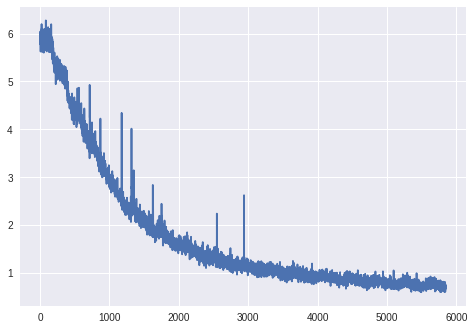

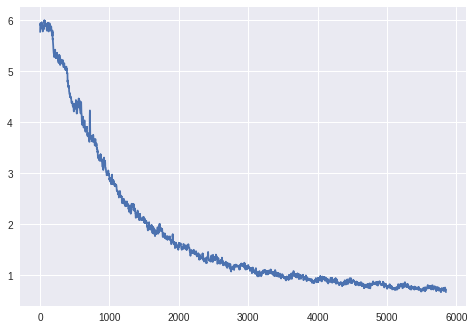

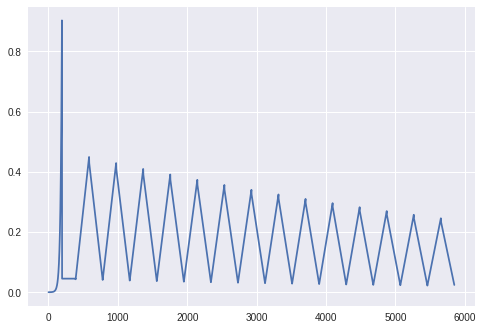

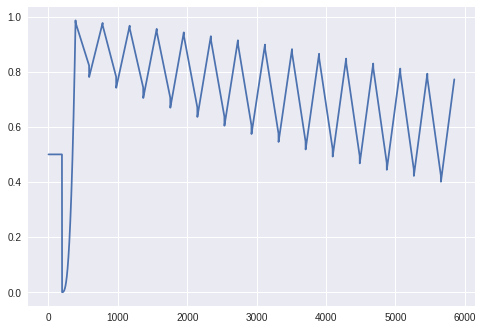

In [16]:


# Score trained model.
#scores = model.evaluate(x_test, y_test, verbose=1)
#print('Test loss:', scores[0])
#print('Test accuracy:', scores[1])

plt.plot(clr_triangular.loss_history)
plt.show()

plt.plot(scipy.signal.medfilt(clr_triangular.loss_history, 9))
plt.show()


#plt.plot(scipy.signal.medfilt(scipy.signal.wiener(clr_triangular.loss_history), 19))
#plt.show()

#plt.plot(scipy.signal.wiener(scipy.signal.medfilt(clr_triangular.loss_history, 19)))
#plt.show()

plt.plot(clr_triangular.lr_history)
plt.show()

#plt.plot(clr_triangular.clipnorm_history)
#plt.show()

plt.plot(clr_triangular.momentum_history)
plt.show()

#plt.plot(clr_triangular.decay_history)
#plt.show()

